In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']

def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": "You are mimicking a real-life person who wants to make friends."},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']

def network_growth(n0, temperature, method='llm'):
    G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]], seed=0)

    Gs = []
    results = []

    for t in G.nodes():

        if method == 'llm':
            result = select_neighbor(G, t, temperature)
            if result:
                v = result['name']
                G.add_edge(t, v)
                results.append(result)
        elif method == 'random':
            v = random.choice(list(set(G.nodes() - set(G.neighbors(t)))))
            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'random'})
        elif method == 'winner':
            v = None,
            max_common_friends = 0
            for u in G.nodes():
                if u not in G.neighbors(t) and u != t and len(set(G.neighbors(u)) & set(G.neighbors(t))) > max_common_friends:
                    v = u
                    max_common_friends = len(set(G.neighbors(u)) & set(G.neighbors(t)))

            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'winner'})

        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature):
    common_friends = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            common_friends.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'group' : 'red' if v < len(G.nodes()) // 2 else 'blue'})

    prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. Each dictionary has three keys: 'name', 'common friends', and 'group'.
    'name' is the name of the person, 'common friends' are the common friends you have with the other person, and 'group' is the group that the other person belongs to.
    The data is given below after chevrons:
    <DEGREES>
    {json.dumps(common_friends, indent=4)}
    </DEGREES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "common_friends" : the common friends of the person you selected,
        "group" : the group that the person you selected belongs to,
        "reason" : reason for selecting the person
    }}

    # Notes
    - The output must be a valid JSON object.

    ```json
    """   

    for i in range(10):
        try:
            result = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():    
                print('COMMON FRIENDS', common_friends)
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None):
    pos = nx.spring_layout(G)
    group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
    group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]

    node_color = ['red' if n in group_1 else 'blue' for n in G.nodes()]

    if not G0:
        nx.draw(G, pos, ax=ax, node_size=10, width=0.1, node_color=node_color, alpha=0.7, edge_color='black')
    else:
        G0_edges = set(G0.edges())
        G_edges = set(G.edges()) - G0_edges

        G_group_1 = set(nx.subgraph(G, group_1).edges()) & G_edges
        G_group_2 = set(nx.subgraph(G, group_2).edges()) & G_edges
        G_between = G_edges - G_group_1 - G_group_2

        nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=0.1, alpha=0.5, edge_color='black', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=G_between, width=0.5, alpha=1, edge_color='orange', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=G_group_1, width=0.5, alpha=1, edge_color='red', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=G_group_2, width=0.5, alpha=1, edge_color='blue', ax=ax)

        nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=node_color, alpha=0.7, ax=ax)

        ax.set_axis_off()

def node_homophily(G, key):
    h = 0
    for v in G.nodes():
        temp = 0
        for u in G.neighbors(v):
            temp += int(G.nodes[v][key] == G.nodes[u][key])
        temp /= G.degree(v)

        h += temp

    return h / G.number_of_nodes()
            
def analyze_experiments(filename):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))


    homophilies = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            Gs.append(G)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        fig.suptitle(f'Graph created based on Principle 3 with $n = {d["n"]}$, temperature={d["temperature"]}')

        for i, t in enumerate([0, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            draw_graph(G, ax=ax[i], G0=Gs[0])

        group = dict([(i, 'red' if i < d['n'] // 2 else 'blue') for i in range(d['n'])])
        [nx.set_node_attributes(G, group, 'group') for G in Gs]

        homophily = [node_homophily(G, 'group') for G in Gs]

        ax[-1].set_title('Metrics')
        ax[-1].plot(homophily, label='Homophily', color='r')

        homophilies[d['n'], d['temperature']].append(homophily)

        fig.tight_layout()
        fig.savefig(f'figures/principle_3/principle_3_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png')

    fig, ax = plt.subplots(1, len(homophilies), figsize=(5 * len(homophilies), 5), squeeze=False)

    for i, k in enumerate(sorted(homophilies.keys())):
        v = homophilies[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))
        
        ax[0, i].plot(mean, color='r', label='LLM')
        ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='r')

        ax[0, i].set_title(f'$n = {k[0]}$, temperature = {k[1]}')

        ax[0, i].set_xlabel('t')
        ax[0, i].set_ylabel('Node Homophily', color='r')

        ax[0, i].set_xlim(0, len(mean) - 1)


    # Null models
    # homophilies_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list) }

    # for d in data:
    #     for method in ['random', 'winner']:
    #         Gs, _ = network_growth(d['n'], d['temperature'], method=method)

    #         homophily = [nx.average_clustering(G) for G in Gs]

    #         homophilies_null[method][d['n'], d['temperature']].append(homophily)


    # for method in ['random', 'winner']:
    #     for i, (k, v) in enumerate(homophilies_null[method].items()):
    #         v = np.array(v)

    #         mean = v.mean(axis=0)
    #         std = v.std(axis=0)

    #         ci = 1.96 * std / np.sqrt(len(v))

    #         if method == 'random':
    #             ax[0, i].plot(mean, color='r', linestyle='--', label=method.capitalize())
    #         elif method == 'winner':
    #             ax[0, i].plot(mean, color='r', linestyle=':', label=method.capitalize())

    #         ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='r')

       
    for i in range(len(homophilies)):
        ax[0, i].legend(loc='upper left')

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_overall.png')
   

In [2]:
# LLM-based
run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_3.jsonl', [0.5, 1.0, 1.5], method='llm')

Running simulation for n=50, i=0, temperature=0.5
COMMON FRIENDS [{'name': 1, 'common_friends': [3, 4, 8, 13, 21], 'group': 'red'}, {'name': 2, 'common_friends': [4, 8, 9, 46, 21], 'group': 'red'}, {'name': 5, 'common_friends': [3, 6, 8, 13, 21], 'group': 'red'}, {'name': 7, 'common_friends': [4, 6, 13, 16, 21], 'group': 'red'}, {'name': 10, 'common_friends': [3, 6, 8, 13, 16], 'group': 'red'}, {'name': 11, 'common_friends': [13, 6], 'group': 'red'}, {'name': 12, 'common_friends': [4, 6, 8, 13, 16], 'group': 'red'}, {'name': 14, 'common_friends': [4, 6, 8, 9, 40, 41, 13], 'group': 'red'}, {'name': 15, 'common_friends': [16], 'group': 'red'}, {'name': 17, 'common_friends': [4, 6, 8, 9, 13, 16], 'group': 'red'}, {'name': 18, 'common_friends': [3, 8, 9, 13, 46, 21, 25], 'group': 'red'}, {'name': 19, 'common_friends': [4, 6, 8, 9, 13, 16, 21, 30], 'group': 'red'}, {'name': 20, 'common_friends': [3, 4, 6, 16, 30], 'group': 'red'}, {'name': 22, 'common_friends': [4, 6, 8, 13, 46, 21], 'group

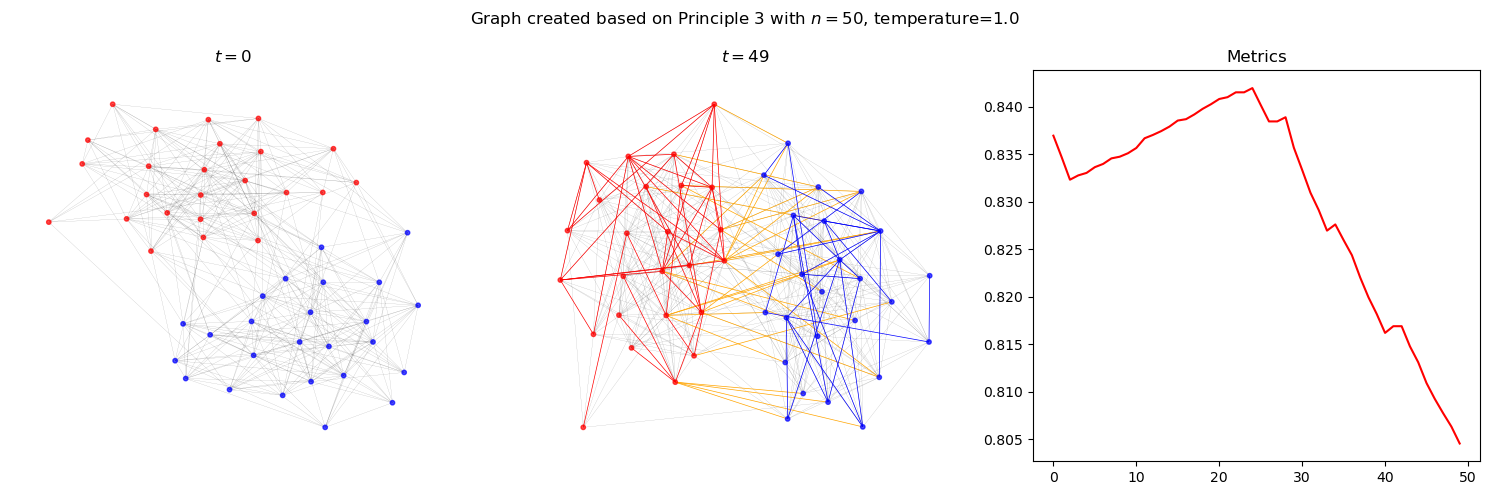

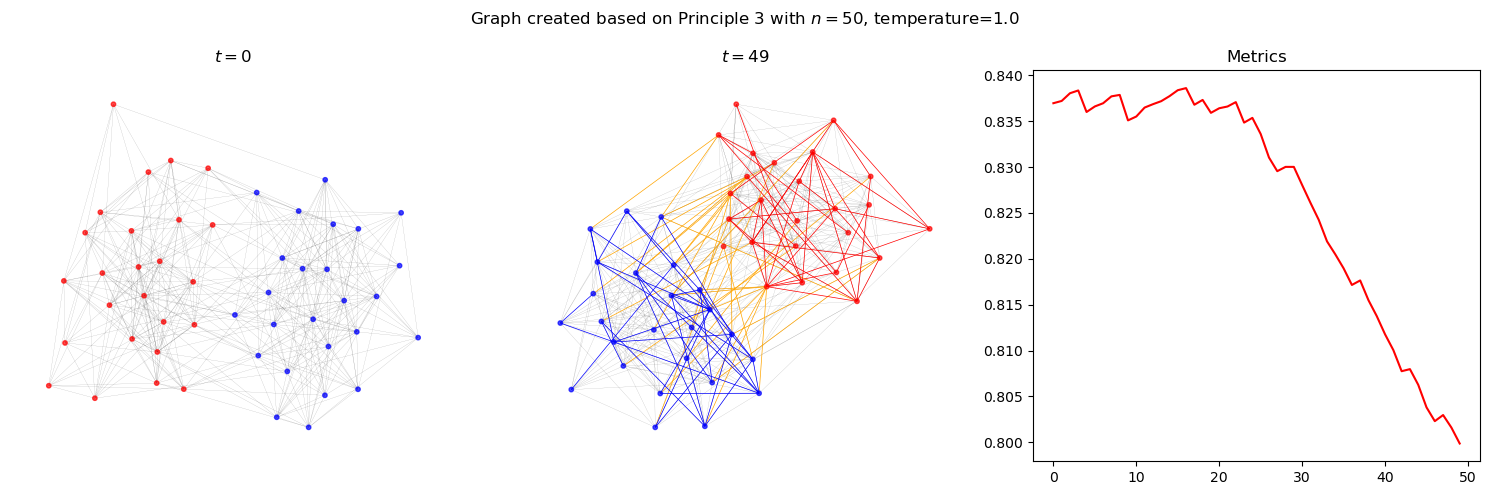

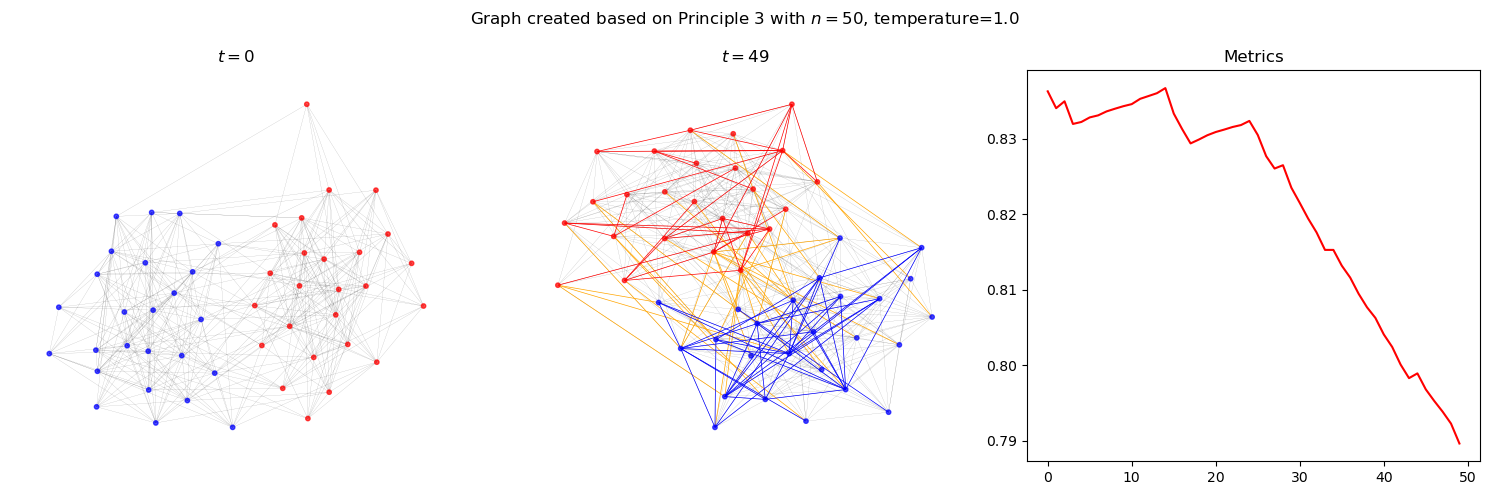

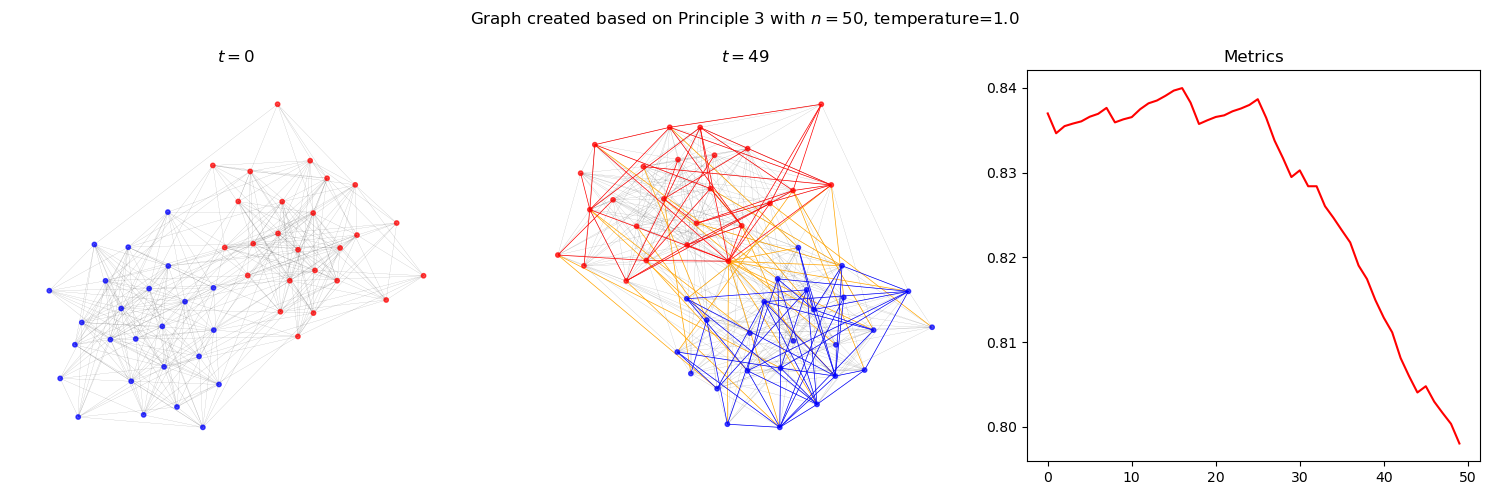

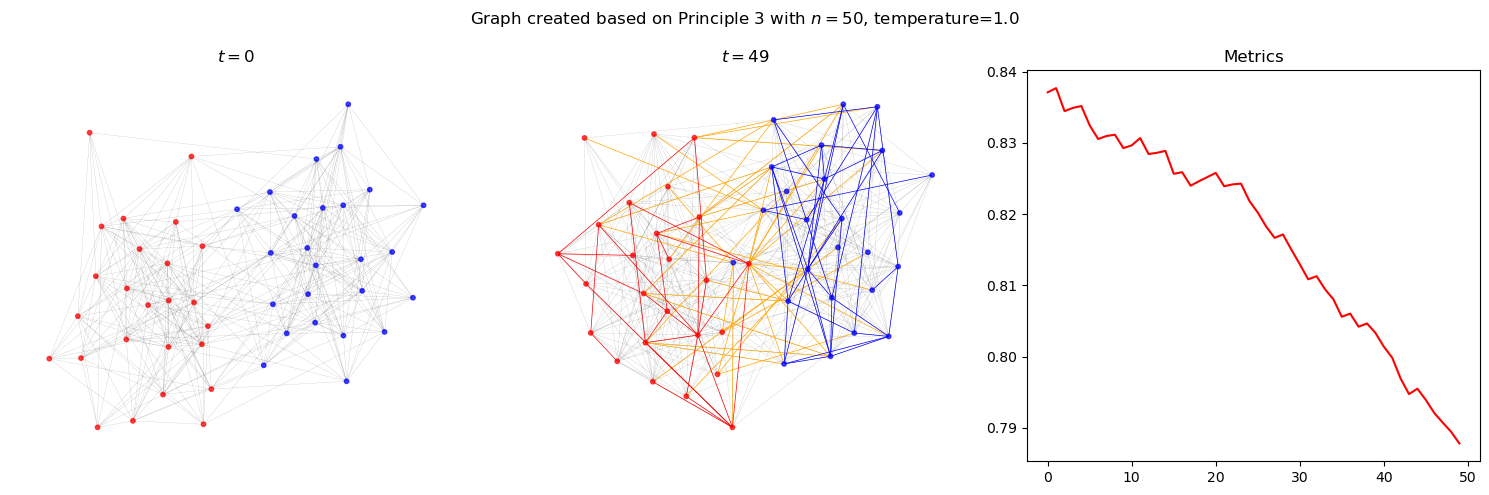

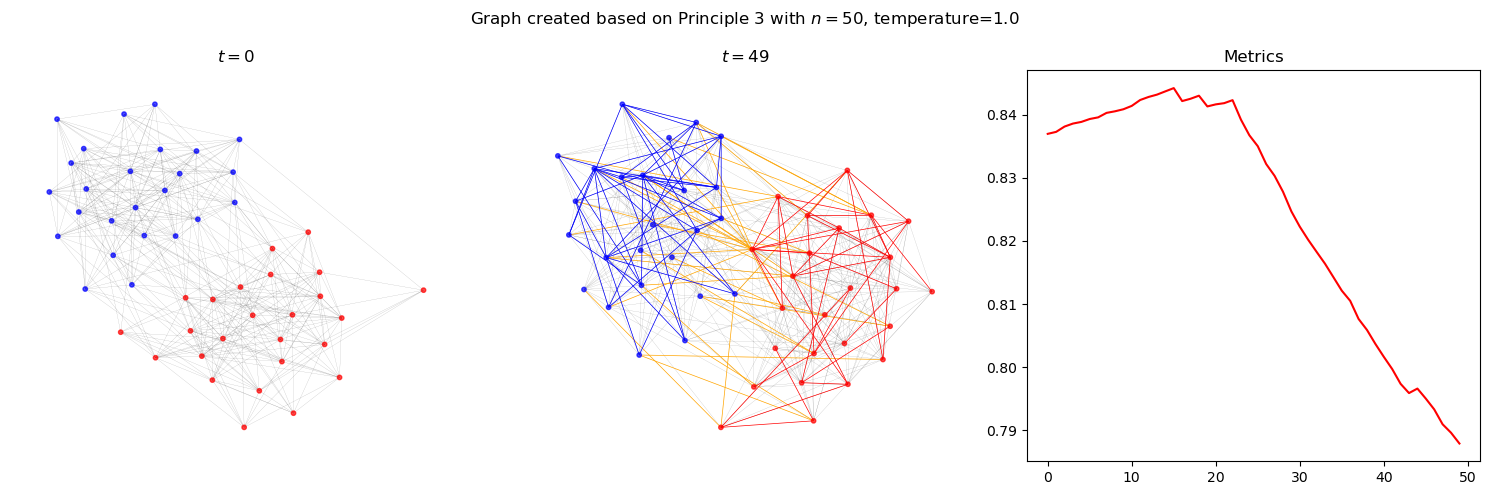

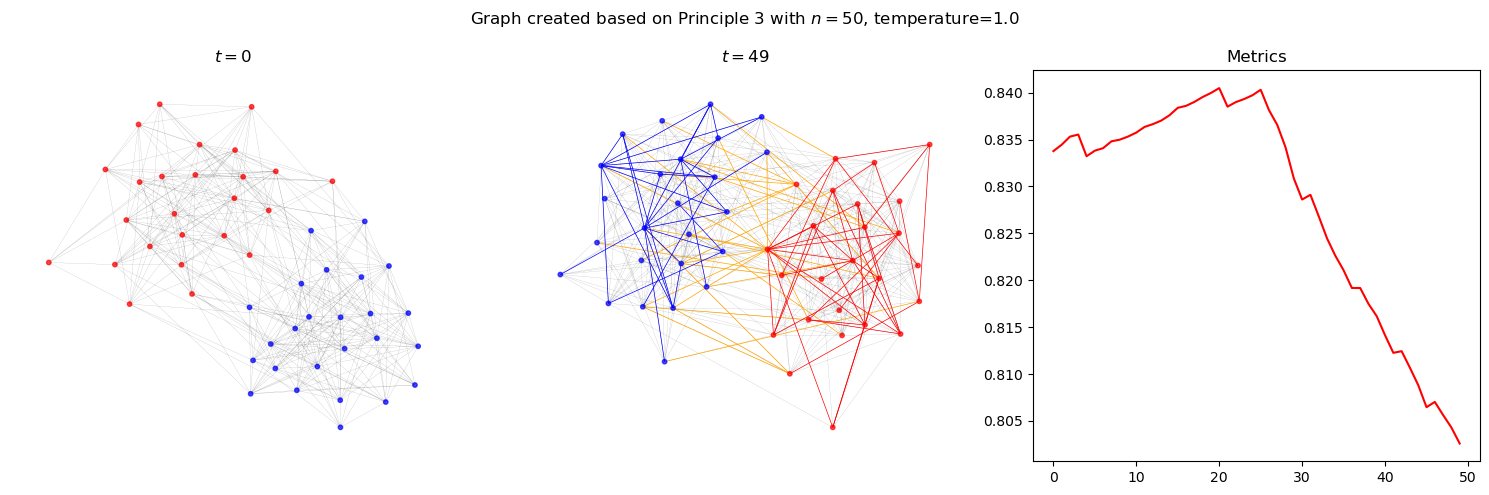

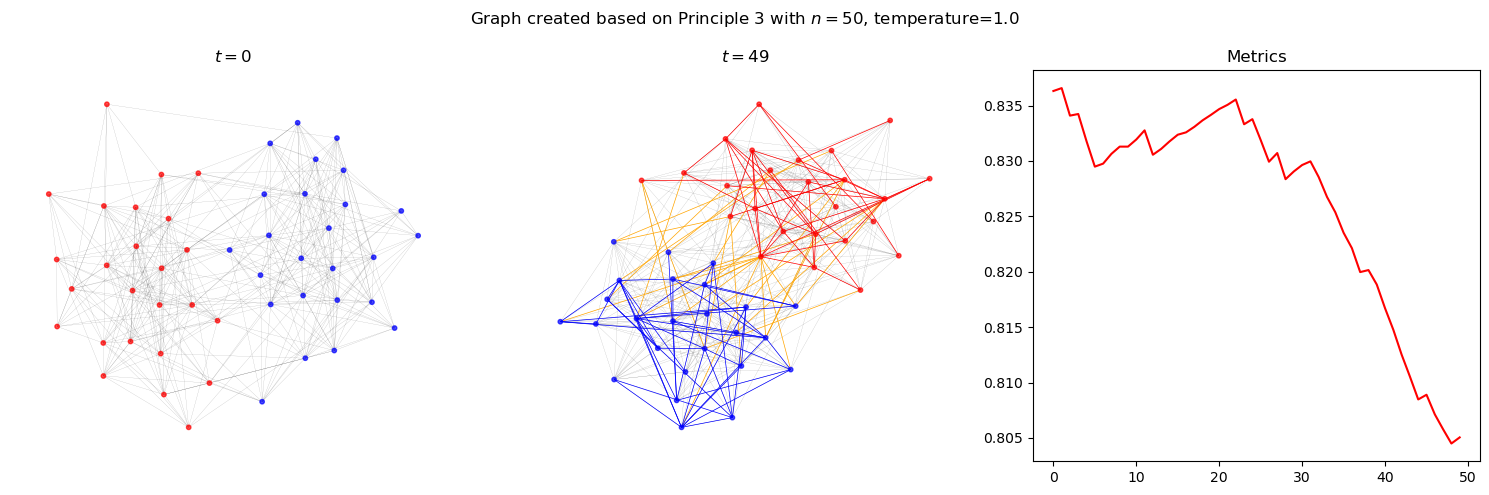

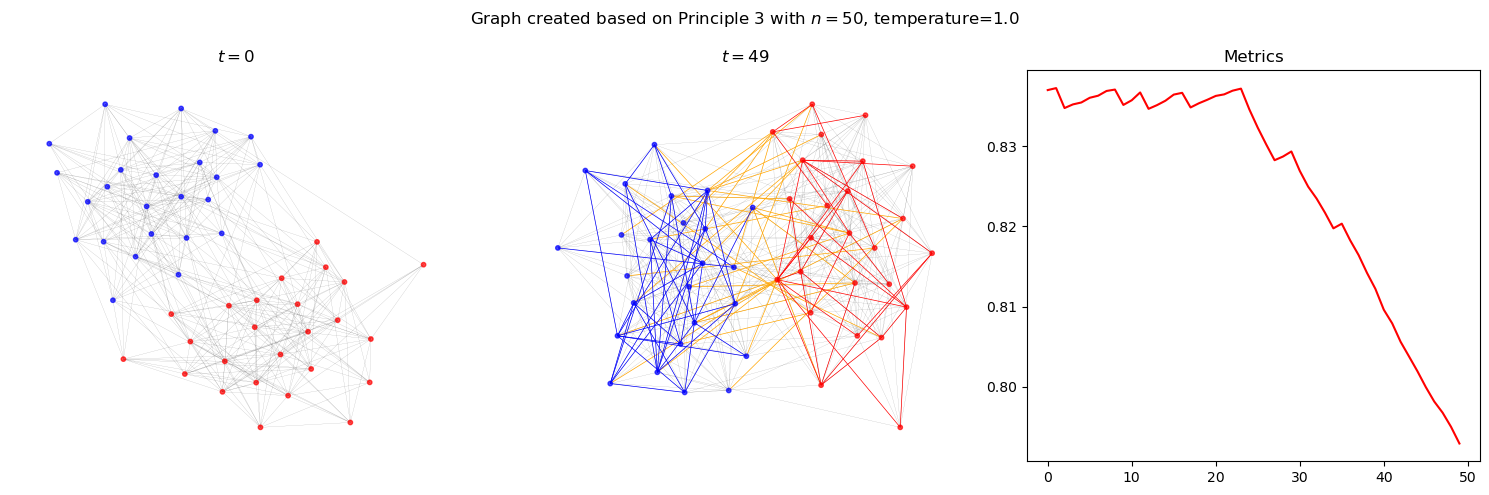

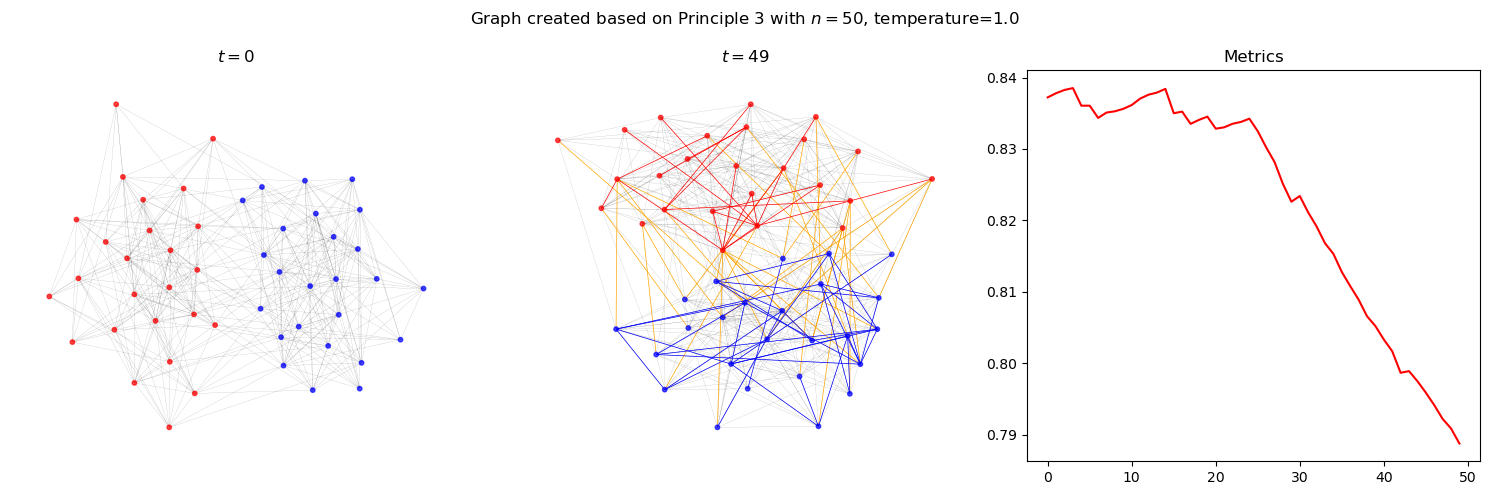

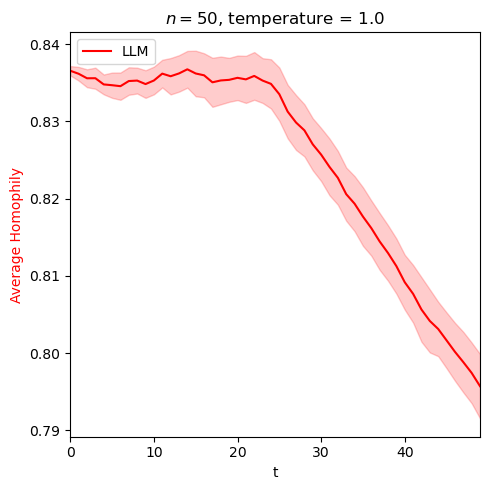

: 

In [ ]:
analyze_experiments('outputs/principle_3.jsonl')